# Deep Learning with Python - Chapter 3

In [1]:
from keras import models, layers
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


## Setup training data

Let's load the IMDB data: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Why use separate training and test sets? Because you should never test a machinelearning model on the same data that you used to train it! Just because a model performs well on its training data doesn’t mean it will perform well on data it has never seen; and what you care about is your model’s performance on new data.

The argument `num_words=10000` means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for *negative* and 1 stands for *positive*.

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

To decode a review from numbers to english:

In [3]:
def decode_review(review):
    word_index         = imdb.get_word_index() # dict[word, int]
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # dict[int, word]
    # Indices are offset by 3 because 0, 1, and 2 are reserved indices for
    # “padding,” “start ofsequence,” and “unknown.”
    words_list = [reverse_word_index.get(i - 3, '?') for i in review]
    return ' '.join(words_list)

decode_review(train_data[0])

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

We need to turn the word lists into tensors. We chose to do it the following way:

One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

10'000 = number of words in the data set.

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [5]:
x_train[0], x_train.shape

(array([0., 1., 1., ..., 0., 0., 0.]), (25000, 10000))

We also need to vectorize the labels

In [6]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Define the network

There are two key architecture decisions to be made about such a stack of Dense layers:
- How many layers to use
- How many hidden units to choose for each layer

In chapter 4, you’ll learn formal principles to guide you in making these choices.
For the time being, you’ll have to trust me with the following architecture choice:
- Two intermediate layers with 16 hidden units each
- A third layer that will output the scalar prediction regarding the sentiment of the current review

notes:
- `relu` zeroes negative values
- `sigmoid` squashes values between 0 and 1

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, you need to choose a loss function and an optimizer.

Because you’re facing a binary classification problem and the output of your network is a probability
(you end your network with a single-unit layer with a sigmoid activation),
it’s best to use the binary_crossentropy loss. It isn’t the only viable choice: you could use, for instance,
mean_squared_error.

But crossentropy is usually the best choice when you’re dealing with models that output probabilities.
Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

`rmsprop`: Divide the gradient by a running average of its recent magnitude

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## Run the network

Use a subset of the training data to validate the experiment.

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val))

Let's plot the training data to see what is happening.

> As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent
optimization—the quantity you’re trying to minimize should be less with
every iteration.

> But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. This is an example of what we warned against earlier: a
model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before.

> In precise terms, what you’re seeing is overfitting:
after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's re-train a network running with fewer epochs to see the result with less overfitting.

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

results

## Using a trained network to generate predictions on new data

> As you can see, the network is confident for some samples (0.99 or more, or 0.01 or
less) but less confident for others (0.6, 0.4).

In [ ]:
model.predict(x_test)

# Exercises

> The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:
> - You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.
> - Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.
> - Try using the mse loss function instead of binary_crossentropy.
> - Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

In [13]:
from keras.utils import plot_model

def create_and_run(layers):
    model = models.Sequential()
    for layer in layers:
        model.add(layer)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    history = model.fit(x_train, y_train, epochs=4, batch_size=512, validation_data=(x_test, y_test))

    plt.clf()
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['acc']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 4s 170us/step - loss: 0.4463 - acc: 0.8230 - val_loss: 0.4131 - val_acc: 0.8149
Epoch 2/4
25000/25000 [==============================] - 5s 217us/step - loss: 0.2576 - acc: 0.9078 - val_loss: 0.2867 - val_acc: 0.8857
Epoch 3/4
25000/25000 [==============================] - 4s 165us/step - loss: 0.1974 - acc: 0.9290 - val_loss: 0.2908 - val_acc: 0.8844
Epoch 4/4
25000/25000 [==============================] - 5s 184us/step - loss: 0.1662 - acc: 0.9396 - val_loss: 0.2962 - val_acc: 0.8822


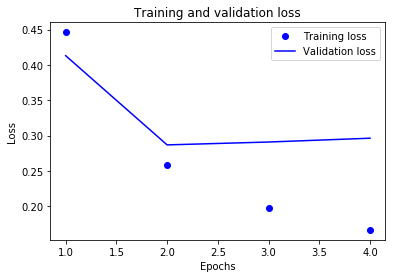

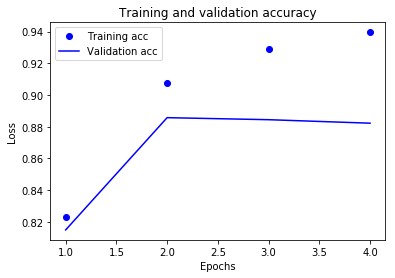

In [10]:
create_and_run([
    layers.Dense(16, activation='relu', input_shape=(10000,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
create_and_run([
    layers.Dense(16, activation='relu', input_shape=(10000,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 5s 202us/step - loss: 0.4198 - acc: 0.8128 - val_loss: 0.3053 - val_acc: 0.8804
Epoch 2/4
25000/25000 [==============================] - 6s 226us/step - loss: 0.2392 - acc: 0.9076 - val_loss: 0.2847 - val_acc: 0.8866
Epoch 3/4
25000/25000 [==============================] - 5s 209us/step 

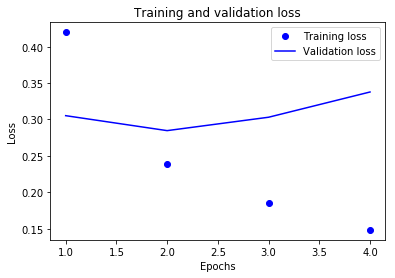

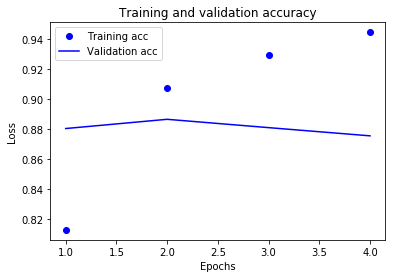

In [14]:
create_and_run([
    layers.Dense(64, activation='relu', input_shape=(10000,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])